# Galaxy classification using CNNs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import random
from PIL import Image

import os

import warnings
warnings.filterwarnings("ignore")

Get data and show example of breakdown of answers for a galaxy

In [440]:
gz5_path = 'C:/Users/mbeye/Downloads/gz_decals_volunteers_5.csv'
gz5_data = pd.read_csv(gz5_path)
gz5_data.columns = gz5_data.columns.str.replace('-', '_').str.replace(' ', '_')
print(gz5_data.head(5).T.to_string())

                                                                             0                                 1                                 2                                 3                                 4
iauname                                                    J112953.88-000427.4               J104325.29+190335.0               J104629.54+115415.1               J082950.68+125621.8               J122056.00-015022.0
ra                                                                  172.474526                        160.856533                        161.623135                         127.46119                        185.233342
dec                                                                  -0.074281                         19.060441                         11.904197                         12.939386                          -1.83934
redshift                                                              0.124142                          0.049088                          0.

In [ ]:
# gz5_data.head(5).T.to_csv('gz5_data_head.csv')

In [234]:
len(gz5_data)

253286

Checking distribution of number of total classification votes for a galaxy

Total number of samples with more than 30 votes:  244091


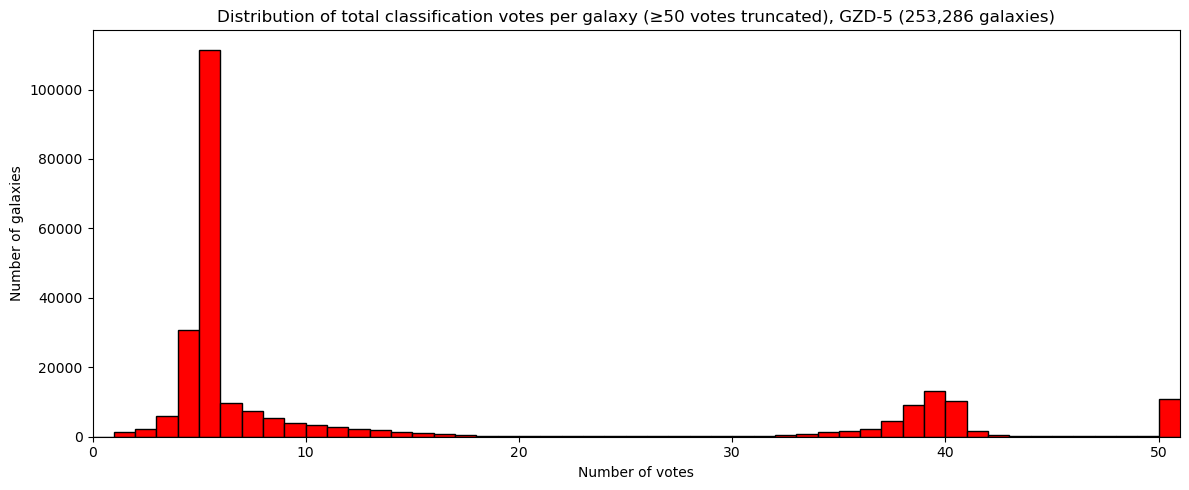

In [435]:
print("Total number of samples with more than 30 votes: ", len(gz5_data[gz5_data['smooth_or_featured_total_votes'] < 60]))

maximum = 50

plt.figure(figsize=(12, 5))
bins = list(range(0, maximum + 1)) + [gz5_data['smooth_or_featured_total_votes'].max() + 1]  # 0-60, plus an overflow bin
plt.hist(gz5_data['smooth_or_featured_total_votes'], bins=bins, edgecolor='k', color='r')
plt.title('Distribution of total classification votes per galaxy (≥50 votes truncated), GZD-5 (253,286 galaxies)')
plt.xlabel('Number of votes')
plt.ylabel('Number of galaxies')
plt.xlim(0, maximum + 1)
plt.tight_layout()
plt.savefig('gz5_votes_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [402]:
max(gz5_data['smooth_or_featured_total_votes'])

303

Reads through all files in the designated directory, and checks that it is found in the GZD-5 data, and then stores the name in ```image_filenames``` if it matches the given conditions (Number of votes > 30 and that ```wrong_size_warning == False```)

In [249]:
validation_galaxies = list(pd.read_csv('C://Users//mbeye//OneDrive//University - MSc @ KU//7. Applied Machine Learning//AML2025_FinalProject//validation_galaxies.csv')['iauname'])
print("Number of validation galaxies:", len(validation_galaxies))

Number of validation galaxies: 3758


In [ ]:
gz5_data_validation = gz5_data[gz5_data['iauname'].isin(validation_galaxies)].reset_index()

3758

In [254]:
gz5_data_training = gz5_data[~gz5_data['iauname'].isin(validation_galaxies)].reset_index()

In [256]:
data_folder_path = 'C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1'

image_filenames = []
image_filepaths = []

n_files_found = 0

# Create a dictionary to hold gz5 data for quick lookup
gz5_dict = {}
for row in gz5_data_training.itertuples(index=False):
    if row.iauname and row.smooth_or_featured_total_votes >= 30: #and not row.wrong_size_warning:
        gz5_dict[row.iauname] = row

# Walk through the directory and find matching .png files by comparing to dictionary
for root, dirs, files in os.walk(data_folder_path):
    for file in files:
        n_files_found += 1
        if file.lower().endswith('.png'):
            base_name = os.path.splitext(file)[0]
            if base_name in gz5_dict:
                image_filenames.append(base_name)
                image_filepaths.append(os.path.join(root, file))

print("Total .png files found:", n_files_found)
print("Total matching images:", len(image_filenames))


Total .png files found: 91481
Total matching images: 15111


Let's try to simplify the labels a little bit more 

In [257]:
gz5_data_reduced = gz5_data[gz5_data['iauname'].isin(image_filenames)].copy().sort_values(by='iauname').reset_index(drop=True)
gz5_data_reduced

iauname          ra        dec  redshift  elpetro_absmag_r  \
0      J000007.82-000226.0    0.032593  -0.040570  0.023664        -19.440268   
1      J000012.78+010712.7    0.053264   1.120225  0.024673        -20.407923   
2      J000127.32+141126.9    0.363885  14.190809  0.095513        -20.495888   
3      J000136.70+033019.9    0.402982   3.505539  0.021145        -18.933426   
4      J000140.21+010531.2    0.417564   1.092012  0.061096        -20.866634   
...                    ...         ...        ...       ...               ...   
15106  J100955.79-030005.0  152.482789  -3.001506  0.067840        -20.751955   
15107  J100958.20-011054.1  152.492511  -1.181877  0.031761        -18.370340   
15108  J100958.73+041559.3  152.494751   4.266462  0.104667        -21.087774   
15109  J100959.04+085917.3  152.496066   8.988163  0.064108        -19.633087   
15110  J100959.09+075227.5  152.496232   7.874308  0.082765        -21.297255   

       sersic_nmgy_r  petro_th50  petro_th90  petro_theta     upload_group  \
0         1073.51260    4.269538   12.730249     9.522999       pre_active   
1         2615.32570   10.394143   21.012920    20.303660       pre_active   
2          173.50429    2.621211    8.270784     5.730439  active_priority   
3          893.94890   11.721440   31.546130    27.973950  active_priority   
4          886.36180    4.664875   14.821093    10.043304       pre_active   
...              ...         ...         ...          ...              ...   
15106      417.24664    3.296629   10.145617     7.958730  active_priority   
15107      228.71190    3.177062    7.670071     6.651412       pre_active   
15108      217.37889    2.479128    8.479074     5.922275       pre_active   
15109      180.82082    2.828788    8.301952     6.410168       pre_active   
15110      669.79270    8.985889   30.571629    29.462809       pre_active   

       ...  merging_minor_disturbance_fraction  \
0      ...                            0.178571   
1      ...                            0.283019   
2      ...                            0.177778   
3      ...                            0.078431   
4      ...                            0.000000   
...    ...                                 ...   
15106  ...                            0.257143   
15107  ...                            0.236842   
15108  ...                            0.121212   
15109  ...                            0.194444   
15110  ...                            0.066667   

       merging_minor_disturbance_debiased merging_major_disturbance  \
0                                0.174051                         2   
1                                0.281042                         6   
2                                0.197576                         0   
3                                0.081724                         0   
4                                0.000000                         0   
...                                   ...                       ...   
15106                            0.269810                         4   
15107                            0.239407                         3   
15108                            0.142782                         0   
15109                            0.203065                         2   
15110                            0.072011                         2   

       merging_major_disturbance_fraction  merging_major_disturbance_debiased  \
0                                0.035714                            0.038462   
1                                0.113208                            0.120000   
2                                0.000000                            0.000000   
3                                0.000000                            0.000000   
4                                0.000000                            0.000000   
...                                   ...                                 ...   
15106                            0.114286                            0.102564   
15107  

In [9]:
gz5_data[gz5_data['iauname'].isin(validation_galaxies['iauname'])].sort_values(by='iauname').reset_index(drop=True)

iauname          ra       dec  redshift  elpetro_absmag_r  \
0     J000134.62+001627.9    0.394284  0.274410  0.062007        -20.907742   
1     J000304.32-004158.4    0.768003 -0.699524  0.031145        -16.639658   
2     J000345.95-045640.3    0.941575 -4.944500  0.101897        -21.198391   
3     J000617.34+002741.0    1.572312  0.461407  0.062063        -20.554962   
4     J000708.36+001535.9    1.784926  0.259961  0.113368        -19.552227   
...                   ...         ...       ...       ...               ...   
3753  J100946.58+070930.3  152.444126  7.158447  0.097966        -21.045294   
3754  J100952.72+045650.1  152.469763  4.947216  0.073667        -19.704980   
3755  J100955.44+092811.3  152.481005  9.469826  0.051166        -20.450460   
3756  J100956.16+084247.5  152.484028  8.713180  0.121756        -21.001211   
3757  J100959.45+064458.5  152.497722  6.749572  0.115226        -20.512627   

      sersic_nmgy_r  petro_th50  petro_th90  petro_theta     upload_group  \
0       1046.298000    1.674800    5.699375     4.113035       pre_active   
1         42.035618    2.391456    5.381819     4.769891  active_priority   
2        309.145050    4.695026   10.527441    10.362074  active_priority   
3        503.475340    1.677593    5.162916     3.663627  active_priority   
4         49.347404    2.845431    7.330372     6.190662  active_priority   
...             ...         ...         ...          ...              ...   
3753     268.820650    2.403030    7.259929     5.566817       pre_active   
3754     139.468960    2.971799    5.927420     5.842183       pre_active   
3755     676.854860    4.949468   11.699411    10.253274       pre_active   
3756     125.516235    1.787275    5.329020     3.923811       pre_active   
3757     105.172035    1.641005    3.401971     3.288916       pre_active   

      ...  merging_minor_disturbance_fraction  \
0     ...                            0.000000   
1     ...                            0.368421   
2     ...                            0.250000   
3     ...                            0.078431   
4     ...                            0.423077   
...   ...                                 ...   
3753  ...                            0.055556   
3754  ...                            0.406250   
3755  ...                            0.257143   
3756  ...                            0.083333   
3757  ...                            0.400000   

      merging_minor_disturbance_debiased merging_major_disturbance  \
0                               0.000000                         0   
1                               0.370789                         0   
2                               0.281998                         2   
3                               0.078368                         1   
4                               0.449383                         3   
...                                  ...                       ...   
3753                            0.066140                         1   
3754                            0.399044                         0   
3755                            0.264012                         7   
3756                            0.103547                         0   
3757                            0.374172                         3   

      merging_major_disturbance_fraction  merging_major_disturbance_debiased  \
0                               0.000000                            0.000000   
1                               0.000000                            0.000000   
2                               0.055556                            0.020000   
3                               0.019608                            0.053333   
4                               0.057692                            0.081081   
...                                  ...                                 ...   
3753                            0.027778                            0.052632   
3754                            0.000000                            0.0000

In [346]:
def gz5_assign_class(df):
    df_votes = pd.DataFrame(df[['iauname', 'smooth_or_featured_total_votes']])
    df_votes.columns = ['iauname', 'total_votes']

    votes_gz5_mapping = {
        'elliptical': 'smooth_or_featured_smooth',
        'lenticular': 'disk_edge_on_yes',
        'spiral': 'has_spiral_arms_yes',
        'irregular': 'has_spiral_arms_no',
        'artifact': 'smooth_or_featured_artifact'
    }

    for key, item in votes_gz5_mapping.items():
        df_votes[key] = df[item] 
    
    df_votes['vote_check'] = df_votes.apply(
        lambda row: np.isclose(row[['elliptical', 'lenticular', 'spiral', 'irregular', 'artifact']].sum(), row['total_votes']), axis=1)

    df_votes['class'] = df_votes.apply(
    lambda row: 'artifact' if row['artifact'] / row['total_votes'] > 0.3 else
                'lenticular' if row['lenticular'] / row['total_votes']  > 0.5 else
                'elliptical' if row['elliptical'] / row['total_votes'] > 0.8 else
                'irregular' if row['irregular'] / row['total_votes'] > 0.5 else
                'spiral' if row['spiral'] / row['total_votes']  > 0.8 else
                'uncertain', axis=1)
    
    return df_votes

gz5_data_votes = gz5_assign_class(gz5_data_reduced)

In [347]:
gz5_data_votes.head(10)

iauname  total_votes  elliptical  lenticular  spiral  \
0  J000007.82-000226.0           59           6           0      45   
1  J000012.78+010712.7           54           6           0      45   
2  J000127.32+141126.9           48           6          39       0   
3  J000136.70+033019.9           53           5          33      10   
4  J000140.21+010531.2           38           6          25       0   
5  J000149.56+003400.9           39          30           0       0   
6  J000219.10+125818.0          100          14           4      71   
7  J000245.40-005936.5           38           7           2      25   
8  J000252.34+010701.5           46           1           2      40   
9  J000304.29+134501.8           90          25           2       7   

   irregular  artifact  vote_check       class  
0          5         3        True   uncertain  
1          2         1        True      spiral  
2          0         3        True  lenticular  
3          3         2        True  lenticular  
4          4         3        True  lenticular  
5          3         6        True   uncertain  
6          6         5        True   uncertain  
7          2         2        True   uncertain  
8          0         3        True      spiral  
9         53         3        True   irregular

In [ ]:



# Artifact > 0.3
# Spiral > 0.7
# Elliptical > 0.7
# Irregular > 0.3
# Lenticular > 0.5

gz5_data_votes['class'].value_counts()

class
uncertain     10242
elliptical     2577
spiral         1263
lenticular      701
artifact        209
irregular       119
Name: count, dtype: int64

In [282]:
gz5_data_votes.head(10)

iauname  total_votes  elliptical  lenticular  spiral  \
0  J000007.82-000226.0           59           6           0      45   
1  J000012.78+010712.7           54           6           0      45   
2  J000127.32+141126.9           48           6          39       0   
3  J000136.70+033019.9           53           5          33      10   
4  J000140.21+010531.2           38           6          25       0   
5  J000149.56+003400.9           39          30           0       0   
6  J000219.10+125818.0          100          14           4      71   
7  J000245.40-005936.5           38           7           2      25   
8  J000252.34+010701.5           46           1           2      40   
9  J000304.29+134501.8           90          25           2       7   

   irregular  artifact  vote_check       class  
0          5         3        True   uncertain  
1          2         1        True      spiral  
2          0         3        True  lenticular  
3          3         2        True  lenticular  
4          4         3        True  lenticular  
5          3         6        True   uncertain  
6          6         5        True   uncertain  
7          2         2        True   uncertain  
8          0         3        True      spiral  
9         53         3        True   irregular

Total number found: 701


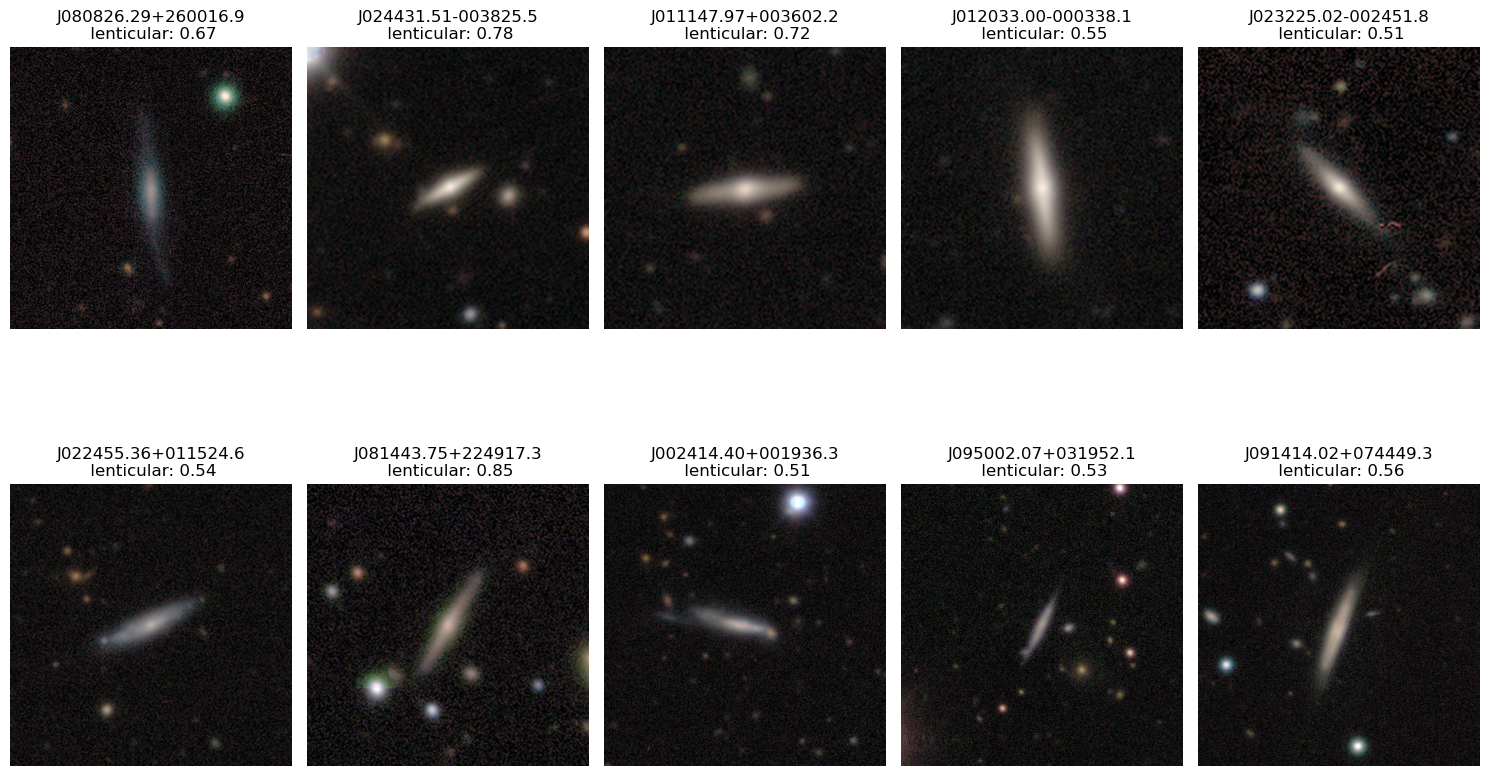

In [283]:
class_in_mind = 'lenticular'

# Get the list of iaunames where spiral/total_votes > 0.75
spiral_galaxies = gz5_data_votes[gz5_data_votes['class'] == class_in_mind]['iauname'].tolist()

print("Total number found:", len(spiral_galaxies))

# Artifact > 0.3
# Spiral > 0.7
# Elliptical > 0.7
# Irregular > 0.3
# Lenticular > 0.5

# Pick 10 random names
sampled_names = random.sample(spiral_galaxies, 10)

#J005253.83-010146.1 lenticular but also an artifact??
#J095320.48+003742.8 lenticular but also an artifact??

root_dir = 'C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1'

plt.figure(figsize=(15, 10))
for i, filename in enumerate(sampled_names):
    subdir = filename[:4]
    image_path = os.path.join(root_dir, subdir, f"{filename}.png")
    if class_in_mind != 'uncertain':
        spiral_frac = gz5_data_votes.loc[gz5_data_votes['iauname'] == filename, class_in_mind].values[0] / \
                    gz5_data_votes.loc[gz5_data_votes['iauname'] == filename, 'total_votes'].values[0]
    else:
        spiral_frac = 0
    if os.path.exists(image_path):
        img = Image.open(image_path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{filename}\n {class_in_mind}: {spiral_frac:.2f}")
    else:
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.title(f"{filename}\nImage not found")
plt.tight_layout()
plt.show()

In [10]:
# # Defining question groups for gz5_data
# gz5_question_groups = ['smooth_or_featured', 'disk_edge', 'has_spiral_arms', 'bar', 'bulge_size', 'how_rounded', 
#                        'edge_on_bulge', 'spiral_winding', 'spiral_arm_count', 'merging']

# # Get a list of all questions in gz5_data (group + sub-question)
# gz5_questions = list(col[:-9] for col in gz5_data.columns if col.endswith('_fraction'))
# for q in gz5_questions: print(q)

In [11]:
# # Grouped outputs you care about
# question_groups = {
#     'smooth_or_featured': ['smooth', 'featured_or_disk', 'artifact'],
#     'disk_edge': ['on_yes', 'on_no'],
#     'has_spiral_arms': ['yes', 'no'],
#     'bar': ['strong', 'weak', 'no'],
#     'bulge_size': ['dominant', 'large', 'moderate', 'small', 'none'],
#     'how_rounded': ['round', 'in_between', 'cigar_shaped'],
#     'edge_on_bulge': ['boxy', 'none', 'rounded'],
#     'spiral_winding': ['tight', 'medium', 'loose'],
#     'spiral_arm_count': ['1', '2', '3', '4', 'more_than_4', 'cant_tell'],
#     'merging': ['none', 'minor_disturbance', 'major_disturbance', 'merger']
# }

In [12]:
# gz5_data_classifications_truth = gz5_data_reduced[['iauname', 
#                                                    'smooth_or_featured_smooth_fraction',
#                                                    'smooth_or_featured_featured_or_disk_fraction',
#                                                    'smooth_or_featured_artifact_fraction'
#                                                    ]]

# gz5_data_classifications_truth['classification'] = gz5_data_classifications_truth.apply(
#     lambda row: 'smooth' if row['smooth_or_featured_smooth_fraction'] > 0.6 else
#                 'featured_or_disk' if row['smooth_or_featured_featured_or_disk_fraction'] > 0.6 else
#                 'artifact' if row['smooth_or_featured_artifact_fraction'] > 0.6 else
#                 'uncertain', axis=1)

# gz5_data_classifications_truth.head(30)

In [13]:
# gz5_data_classifications_truth['classification'].value_counts().plot(kind='barh', color='skyblue', edgecolor='black')
# print("Total number of images:", len(gz5_data_classifications_truth), '\n')
# print(gz5_data_classifications_truth['classification'].value_counts())

Setting up training data for model

In [ ]:
# from tqdm import tqdm
# from PIL import Image
# import os
# import numpy as np
# import pandas as pd

# def load_images(image_list, image_dir):
#     X_data = []
#     y_data = []

#     # Convert to dictionary for fast lookup
#     gz5_dict = gz5_data_reduced.set_index('iauname').to_dict(orient='index')

#     not_found_count = 0

#     # Limit for testing
#     for name in tqdm(image_list, desc="Loading images and labels"):
#         if name not in gz5_dict:
#             not_found_count += 1
#             continue

#         row = gz5_dict[name]
        
#         subdir = name[:4]
#         path = os.path.join(image_dir, subdir, f"{name}.png")
#         try:
#             img = Image.open(path).convert('RGB').resize((424, 424))
#         except:
#             continue  # Skip corrupted or missing images

#         img_array = np.array(img, dtype=np.float32) / 255.0
#         X_data.append(img_array)

#         label = [
#             row.get('elliptical', 0.0),
#             row.get('spiral', 0.0),
#             row.get('edge-on-disk', 0.0),
#             row.get('irregular', 0.0),
#             row.get('artifact', 0.0)
#         ]
#         y_data.append(label)

#     print(f"Number of images not found: {not_found_count}")

#     # Convert to arrays
#     X_data = np.array(X_data, dtype=np.float32)
#     y_data = np.array(y_data, dtype=np.float32)

#     return X_data, y_data   


In [284]:
gz5_data_classes = gz5_data_votes[
    ~gz5_data_votes['class'].isin(['artifact', 'uncertain'])
][['iauname', 'class']].reset_index(drop=True)

gz5_data_classes['class'].value_counts()

class
elliptical    2577
spiral        1263
lenticular     701
irregular      119
Name: count, dtype: int64

In [285]:
gz5_data_classes.head(10)

iauname       class
0  J000012.78+010712.7      spiral
1  J000127.32+141126.9  lenticular
2  J000136.70+033019.9  lenticular
3  J000140.21+010531.2  lenticular
4  J000252.34+010701.5      spiral
5  J000304.29+134501.8   irregular
6  J000413.84+010004.2  elliptical
7  J000608.61-072401.4  elliptical
8  J000628.34+003018.8      spiral
9  J000806.99+094302.9      spiral

In [286]:
import pandas as pd
import numpy as np

def create_balanced_augmented_df(df, target_count=3000):
    classes = ['elliptical', 'spiral', 'irregular', 'lenticular']
    balanced_rows = []

    for cls in classes:
        cls_df = df[df['class'] == cls]
        current_count = len(cls_df)

        if current_count > target_count:
            # Undersample
            sampled = cls_df.sample(target_count, random_state=42)
            sampled['aug_type'] = 'original'
            balanced_rows.append(sampled)

        elif current_count == target_count:
            cls_df = cls_df.copy()
            cls_df['aug_type'] = 'original'
            balanced_rows.append(cls_df)

        else:
            # Keep original
            orig = cls_df.copy()
            orig['aug_type'] = 'original'

            # Duplicate samples for augmentation
            n_needed = target_count - current_count
            aug_samples = cls_df.sample(n_needed, replace=True, random_state=42).copy()
            aug_samples['aug_type'] = np.random.choice(
                ['flip', 'rotate_90', 'rotate_180', 'rotate_270'],
                size=len(aug_samples)
            )

            balanced_rows.extend([orig, aug_samples])

    return pd.concat(balanced_rows).sample(frac=1).reset_index(drop=True)


In [287]:
from tensorflow.keras.utils import Sequence
from PIL import Image, ImageOps
import numpy as np
import os

class GalaxyDataGenerator(Sequence):
    def __init__(self, df, image_dir, batch_size=16, input_shape=(224, 224), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.classes = ['elliptical', 'lenticular', 'spiral', 'irregular']
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        if index >= self.__len__():
            raise IndexError(f"Index {index} out of range for generator of length {self.__len__()}")
        
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[idxs]

        X = np.zeros((len(batch_df), *self.input_shape, 3), dtype=np.float32)
        y = np.zeros((len(batch_df), len(self.classes)), dtype=np.float32)

        any_valid_images = False

        for i, (_, row) in enumerate(batch_df.iterrows()):
            name = row.get('iauname', None)
            class_label = row.get('class', None)
            aug_type = row.get('aug_type', 'original')

            if name is None or class_label not in self.classes:
                print(f"Skipping row — invalid name or class: {name}, {class_label}")
                continue

            subdir = name[:4]
            img_path = os.path.join(self.image_dir, subdir, f"{name}.png")

            try:
                img = Image.open(img_path).convert('RGB').resize(self.input_shape)

                # Apply augmentation
                if aug_type == 'flip':
                    img = ImageOps.mirror(img)
                elif aug_type == 'rotate_90':
                    img = img.rotate(90)
                elif aug_type == 'rotate_180':
                    img = img.rotate(180)
                elif aug_type == 'rotate_270':
                    img = img.rotate(270)

                X[i] = np.array(img) / 255.0

                label = np.zeros(len(self.classes))
                label[self.classes.index(class_label)] = 1.0
                y[i] = label

                any_valid_images = True

            except Exception as e:
                print(f"Skipping {img_path}: {e}")
                continue

        if not any_valid_images:
            # You can choose to raise here to debug or just return an empty batch
            return np.empty((0, *self.input_shape, 3)), np.empty((0, len(self.classes)))

        return X, y


In [385]:
gz5_data_classes_aug = create_balanced_augmented_df(gz5_data_classes, target_count=3000)

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(gz5_data_classes_aug, test_size=0.25)

train_gen = GalaxyDataGenerator(train_df, image_dir='C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1', batch_size=32)
val_gen = GalaxyDataGenerator(val_df, image_dir='C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1', batch_size=32)

print(f"Number of training samples: {len(train_df)}")
print(f"Number of testing samples: {len(val_df)}")

Number of training samples: 9000
Number of testing samples: 3000


In [299]:
# image_filenames_train = list(set(image_filenames) - set(validation_galaxies['iauname']))
# print("Number of training images:", len(image_filenames_train))

# image_filenames_val = list(validation_galaxies['iauname'])
# print("Number of validation images:", len(image_filenames_val))

# print("Total number of images:" , len(image_filenames_train) + len(image_filenames_val))

In [16]:
# X_train, y_train = load_images(image_filenames, image_dir='C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1')

# print("X_data shape:", X_train.shape)
# print("y_data shape:", y_train.shape)

In [17]:
# X_val, y_val = load_images(list(validation_galaxies['iauname']), image_dir='C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1')
# print("X_data shape:", X_val.shape)
# print("y_data shape:", y_val.shape)

In [386]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_galaxy_model(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# vote_columns = ['elliptical', 'lenticular', 'spiral', 'irregular', 'artifact']

# train_df = gz5_data_votes[gz5_data_votes['iauname'].isin(image_filenames_train)].copy()
# train_df[vote_columns] = train_df[vote_columns].div(train_df['total_votes'], axis=0)
# train_df = train_df.drop(columns=['vote_check', 'total_votes'])

# val_df = gz5_data_votes[gz5_data_votes['iauname'].isin(image_filenames_val)].copy()
# val_df[vote_columns] = val_df[vote_columns].div(val_df['total_votes'], axis=0)
# val_df = val_df.drop(columns=['vote_check', 'total_votes'])

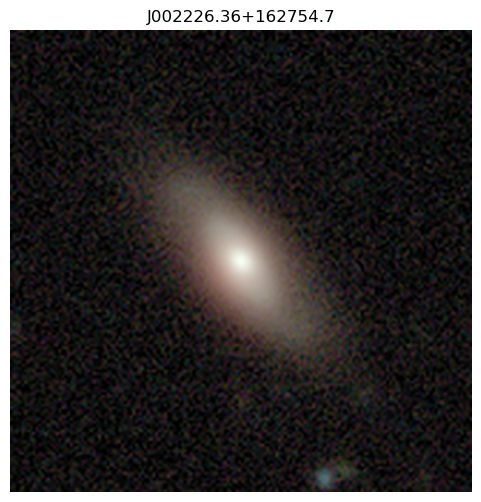

In [301]:
import os
from PIL import Image
import matplotlib.pyplot as plt

root_dir = 'C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1'

filename = 'J002226.36+162754.7'
subdir = filename[:4]
image_path = os.path.join(root_dir, subdir, f"{filename}.png")

# Load and show image
if os.path.exists(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(filename)
    plt.show()
else:
    print(f"Image not found at: {image_path}")


In [387]:
model = build_galaxy_model()
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │     8,652,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,746,552 (33.37 MB)

 Trainable params: 8,746,552 (33.37 MB)

 Non-trainable params: 0 (0.00 B)

In [388]:
X_batch, y_batch = next(iter(train_gen))
print("X_batch shape:", X_batch.shape)  # Should be (batch_size, 224, 224, 3)
print("y_batch shape:", y_batch.shape)  # Should be (batch_size, 4)

X_batch shape: (32, 224, 224, 3)
y_batch shape: (32, 4)


In [389]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[early_stop])

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.2964 - loss: 1.3739 - val_accuracy: 0.4713 - val_loss: 1.2602
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.4771 - loss: 1.1760 - val_accuracy: 0.4923 - val_loss: 1.1035
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.5529 - loss: 1.0400 - val_accuracy: 0.5193 - val_loss: 1.0436
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.6026 - loss: 0.9063 - val_accuracy: 0.5920 - val_loss: 0.9444
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.6476 - loss: 0.8342 - val_accuracy: 0.6783 - val_loss: 0.8315
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.6801 - loss: 0.7760 - val_accuracy: 0.6813 - val_loss: 0.7681
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.6881 - loss: 0.7427 - val_accuracy: 0.6947 - val_loss: 0.8026
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.7045 - loss: 0.7066 - val_accu

In [97]:
# X_batch, y_batch = val_gen[0]
# print("Sample labels:\n", y_batch[0:700])

In [390]:
predictions = []
ground_truth = []

iaunames = []

for batch_imgs, batch_labels in val_gen:
    if batch_imgs.shape[0] == 0:
        print("Empty batch encountered. Skipping.")
        continue
    preds = model.predict(batch_imgs, verbose=0)
    predictions.append(preds)
    ground_truth.append(batch_labels)

    # If using a custom generator, get matching iaunames from df slice
    batch_size = batch_imgs.shape[0]
    start_idx = len(iaunames)
    end_idx = start_idx + batch_size
    iaunames.extend(train_df['iauname'].iloc[start_idx:end_idx].tolist())

    if len(iaunames) >= len(train_df):
        break

y_pred = np.vstack(predictions)
y_true = np.vstack(ground_truth)

# pred_probs = pd.DataFrame(y_pred, columns=['elliptical', 'lenticular', 'spiral', 'irregular', 'artifact'])
# pred_df = pd.concat([pd.Series(iaunames, name='iauname'), pred_probs], axis=1)

# true_df = val_df[['iauname', 'elliptical', 'lenticular', 'spiral', 'irregular', 'artifact']].reset_index(drop=True)

# merged_df = pred_df.merge(true_df, on='iauname', suffixes=('_pred', '_true'))

# for col in ['elliptical', 'lenticular', 'spiral', 'irregular', 'artifact']:
#     merged_df[f'{col}_absdiff'] = np.abs(merged_df[f'{col}_pred'] - merged_df[f'{col}_true'])


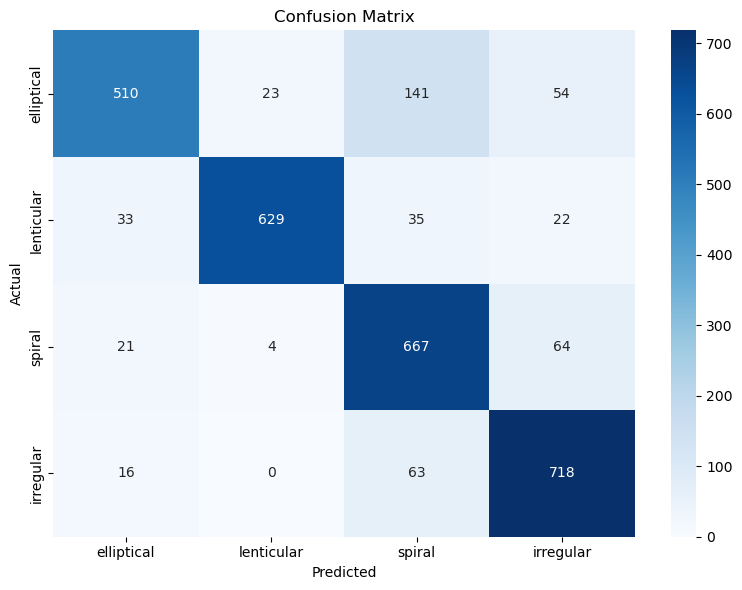

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to hard labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Define class labels (in the same order used during training)
class_names = ['elliptical', 'lenticular', 'spiral', 'irregular']

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [392]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

micro_f1 = f1_score(y_true_labels, y_pred_labels, average="micro")
macro_f1 = f1_score(y_true_labels, y_pred_labels, average="macro")
print(f"Micro-F1: {micro_f1:.4f}")
print(f"Macro-F1: {macro_f1:.4f}\n")

              precision    recall  f1-score   support

  elliptical       0.88      0.70      0.78       728
  lenticular       0.96      0.87      0.91       719
      spiral       0.74      0.88      0.80       756
   irregular       0.84      0.90      0.87       797

    accuracy                           0.84      3000
   macro avg       0.85      0.84      0.84      3000
weighted avg       0.85      0.84      0.84      3000

Micro-F1: 0.8413
Macro-F1: 0.8413



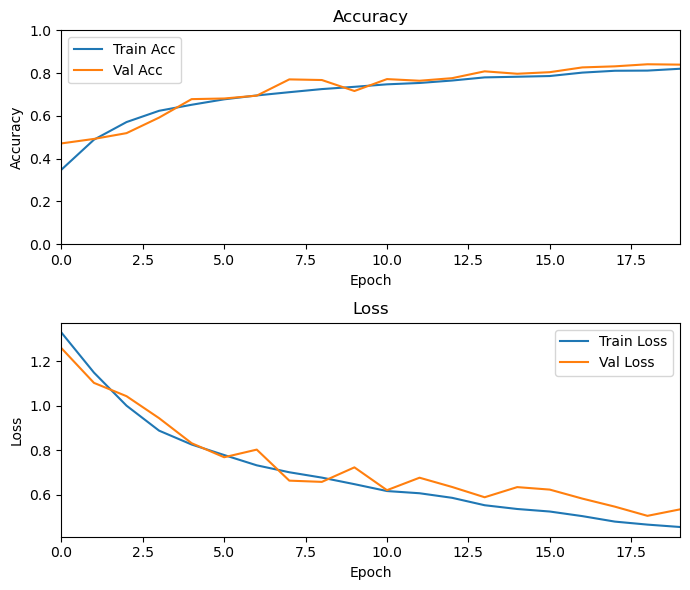

In [467]:
# Plot accuracy and loss curves
plt.figure(figsize=(7, 6))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0, 19)
plt.ylim(0, 1)
plt.legend()

# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 19)
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()


In [462]:
gz5_assign_class(gz5_data_validation).drop(columns=['class', 'vote_check'])

iauname  total_votes  elliptical  lenticular  spiral  \
0     J100927.56+071112.4           34          14           1       7   
1     J002445.21-011204.1           39          25           3       1   
2     J010336.58-005048.2           38          30           0       0   
3     J013808.65-001936.6           40          16           4       1   
4     J013003.42-011020.8           40          27           1       0   
...                   ...          ...         ...         ...     ...   
3753  J092939.72+074551.9           39          23           4       0   
3754  J094808.75+235401.7           44          21           0      15   
3755  J010517.85-003541.9           38          16           8       4   
3756  J080950.66+064252.2           63          33          17       0   
3757  J093830.35+055025.0           38          36           0       1   

      irregular  artifact  
0            10         2  
1             7         3  
2             5         3  
3            10         9  
4            12         0  
...         ...       ...  
3753          4         8  
3754          3         5  
3755          8         2  
3756          2        11  
3757          1         0  

[3758 rows x 7 columns]

In [ ]:
def classify_from_votes(vote_dict, total_votes):
    if vote_dict['artifact'] / total_votes > 0.3:
        return 'uncertain'
    elif vote_dict['lenticular'] / total_votes > 0.5:
        return 'lenticular'
    elif vote_dict['elliptical'] / total_votes > 0.8:
        return 'elliptical'
    elif vote_dict['irregular'] / total_votes > 0.5:
        return 'irregular'
    elif vote_dict['spiral'] / total_votes > 0.8:
        return 'spiral'
    else:
        return 'uncertain'

# Replace this with your actual DataFrame of validation votes
# df_votes should include columns: elliptical, lenticular, spiral, irregular, artifact, total_votes, iauname

df_votes['class'] = df_votes.apply(
    lambda row: classify_from_votes(row, row['total_votes']),
    axis=1
)


In [463]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Your filenames and true labels
# image_filenames = list(gz5_assign_class(gz5_data_validation)['iauname'])
# true_labels = list(gz5_assign_class(gz5_data_validation)['class'])

# class_names = ['elliptical', 'lenticular', 'spiral', 'irregular']

# y_pred_labels = []
# y_true_labels = []

def prepare_image_for_model(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')       # Ensure 3 channels
    img = img.resize(target_size)                     # Resize to match model input
    img_array = np.array(img) / 255.0                 # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)     # Add batch dimension
    return img_array  # shape: (1, 224, 224, 3)

def classification_prediction(image_path, model):
    image_tensor = prepare_image_for_model(image_path)
    prediction = model.predict(image_tensor, verbose=0)
    
    class_names_4 = ['elliptical', 'lenticular', 'spiral', 'irregular']
    prediction_dict = {
        class_names_4[i]: float(prediction[0][i]) for i in range(len(class_names_4))
    }
    return prediction_dict

def classify_from_probs(prob_dict):
    if prob_dict['lenticular'] > 0.5:
        return 'lenticular'
    elif prob_dict['elliptical'] > 0.8:
        return 'elliptical'
    elif prob_dict['irregular'] > 0.5:
        return 'irregular'
    elif prob_dict['spiral'] > 0.8:
        return 'spiral'
    else:
        return 'uncertain'
    
def classify_from_votes(row):
    if row['artifact'] / row['total_votes'] > 0.3:
        return 'uncertain'
    elif row['lenticular'] / row['total_votes'] > 0.5:
        return 'lenticular'
    elif row['elliptical'] / row['total_votes'] > 0.8:
        return 'elliptical'
    elif row['irregular'] / row['total_votes'] > 0.5:
        return 'irregular'
    elif row['spiral'] / row['total_votes'] > 0.8:
        return 'spiral'
    else:
        return 'uncertain'

def evaluate_model_on_files(model, df_votes, root_dir):
    class_names = ['elliptical', 'lenticular', 'spiral', 'irregular', 'uncertain']
    
    y_pred_labels = []
    y_true_labels = []

    # Apply pre-classification to vote data
    df_votes['true_class'] = df_votes.apply(classify_from_votes, axis=1)

    for idx, row in df_votes.iterrows():
        filename = row['iauname']
        true_label = row['true_class']
        
        if true_label not in class_names:
            continue

        subdir = filename[:4]
        image_path = os.path.join(root_dir, subdir, f"{filename}.png")

        if not os.path.exists(image_path):
            continue

        try:
            probs = classification_prediction(image_path, model)
        except:
            continue

        pred_class = classify_from_probs(probs)

        y_pred_labels.append(class_names.index(pred_class))
        y_true_labels.append(class_names.index(true_label))

    # Evaluation
    print("\nClassification Report:\n")
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=range(len(class_names)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Classification Report:

              precision    recall  f1-score   support

  elliptical       0.41      0.35      0.38       594
  lenticular       0.30      0.77      0.43       181
      spiral       0.25      0.61      0.35       310
   irregular       0.03      0.31      0.05        32
   uncertain       0.74      0.46      0.57      2641

    accuracy                           0.47      3758
   macro avg       0.35      0.50      0.36      3758
weighted avg       0.62      0.47      0.51      3758



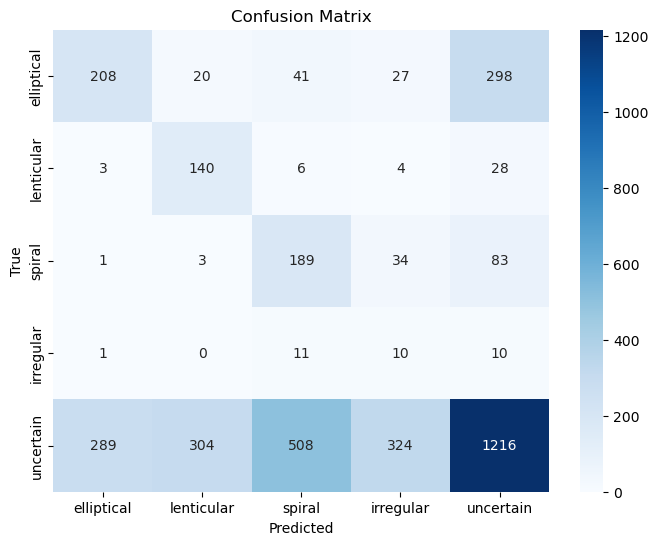

In [464]:
root_dir = 'C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1'

df_votes = gz5_assign_class(gz5_data_validation).drop(columns=['class', 'vote_check'])
evaluate_model_on_files(model, df_votes, root_dir)

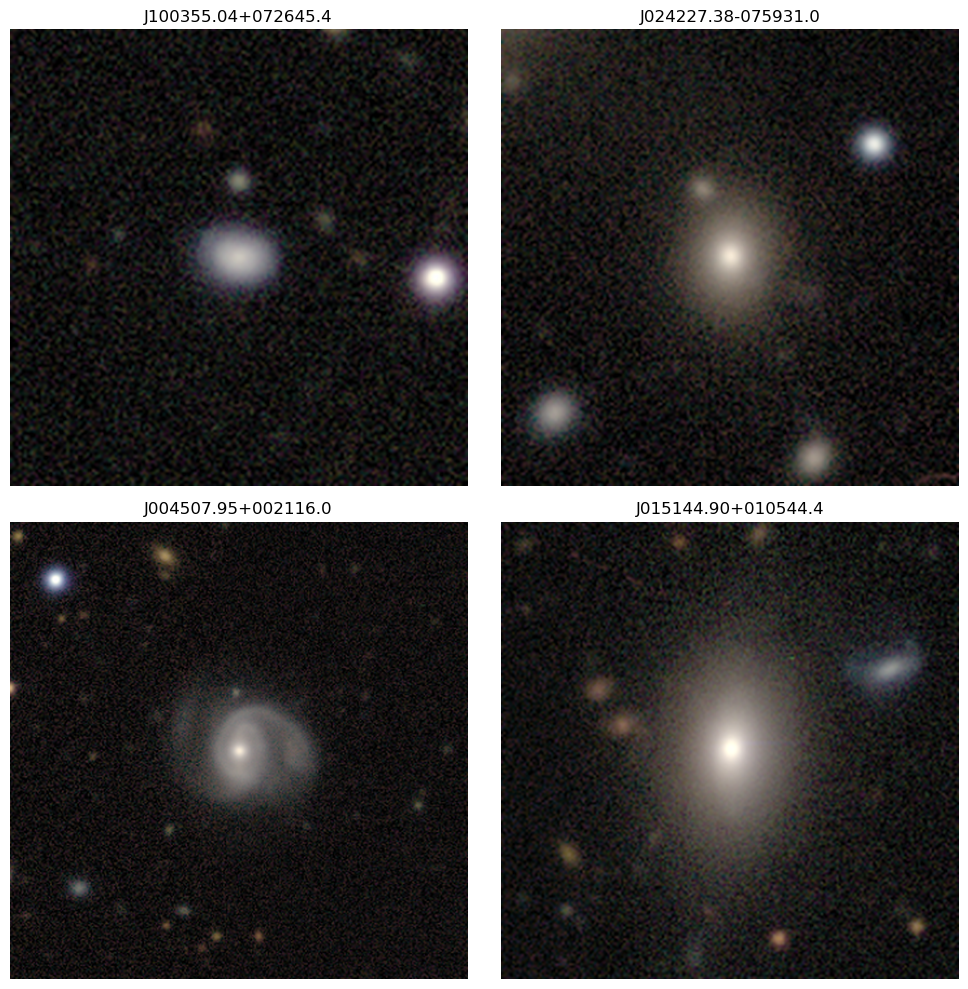

In [214]:
import os
from PIL import Image
import matplotlib.pyplot as plt

verification_galaxy_names = [
    'J100355.04+072645.4',
    'J024227.38-075931.0',
    'J004507.95+002116.0',
    'J015144.90+010544.4'
]

root_dir = 'C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1'

plt.figure(figsize=(10, 10))
for i, filename in enumerate(verification_galaxy_names):
    subdir = filename[:4]
    image_path = os.path.join(root_dir, subdir, f"{filename}.png")

    plt.subplot(2, 2, i + 1)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)
    else:
        plt.axis('off')
        plt.title(f"{filename}\nImage not found")
plt.tight_layout()
plt.show()

In [350]:
val_set_classified = gz5_assign_class(gz5_data_validation)

In [355]:
gz5_assign_class(gz5_data[gz5_data['iauname'].isin(verification_galaxy_names)])

iauname  total_votes  elliptical  lenticular  spiral  \
80615   J004507.95+002116.0           40           1           1      37   
101280  J024227.38-075931.0           40          31           0       0   
182290  J100355.04+072645.4           38          32           0       1   
230475  J015144.90+010544.4           39          26           3       0   

        irregular  artifact  vote_check       class  
80615           0         1        True      spiral  
101280          4         5        True   uncertain  
182290          2         3        True  elliptical  
230475          9         1        True   uncertain

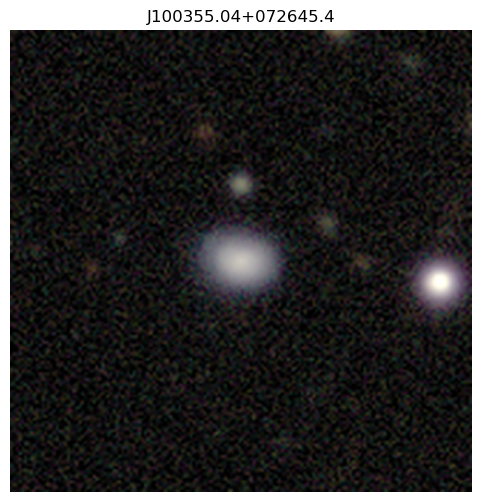

In [394]:
def show_photo(filename):
    subdir = filename[:4]
    image_path = os.path.join('C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1', subdir, f"{filename}.png")
    img = Image.open(image_path)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(filename)
    plt.show()

show_photo('J100355.04+072645.4')

In [ ]:
from PIL import Image
import numpy as np



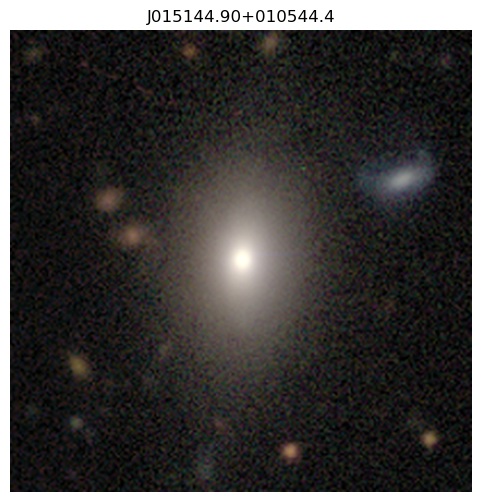

In [ ]:


    # # Get index of highest probability
    # y_pred_label = np.argmax(y_pred, axis=1)[0]  # 2

    # # Map to class name
    # predicted_class = class_names[y_pred_label]

    # print("Predicted class:", predicted_class, f"({float(np.max(y_pred, axis=1)):.0%})")

galaxy_prediction = classification_prediction('J004507.95+002116.0')
show_photo('J015144.90+010544.4')

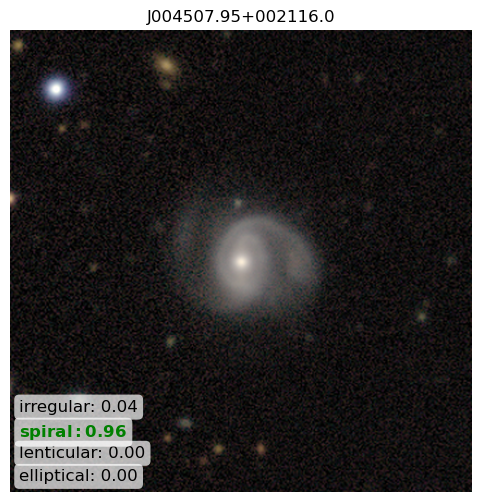

In [424]:
def show_photo_with_prediction(filename):
    # Load image
    subdir = filename[:4]
    image_path = os.path.join('C:/Users/mbeye/Downloads/gz_decals_dr5_png_part1', subdir, f"{filename}.png")
    img = Image.open(image_path)

    # Get prediction
    prediction = classification_prediction(filename)
    best_label = max(prediction, key=prediction.get)

    # Format prediction text
    label_lines = []
    for label, value in prediction.items():
        formatted = f"{label}: {value:.2f}"
        if label == best_label:
            formatted = f"$\\bf{{{formatted}}}$"  # bold using LaTeX
            color = 'green'
        else:
            color = 'black'
        label_lines.append((formatted, color))

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(filename)

    # Add text box in top-left corner
    text_str = "\n".join([f"{line[0]}" for line in label_lines])
    colors = [line[1] for line in label_lines]
    
    # Display line-by-line to allow individual coloring
    y_start = 0.05
    for i, (text, color) in enumerate(zip(text_str.split("\n"), colors)):
        plt.text(0.02, y_start + i*0.05, text, transform=plt.gca().transAxes,
                 fontsize=12, color=color, verticalalignment='top',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round, pad=0.3'))

    plt.show()

# Example call
show_photo_with_prediction('J004507.95+002116.0')

In [183]:
# merged_df['irregular_pred'].hist(bins=20, alpha=0.4, label='pred')
# merged_df['irregular_true'].hist(bins=20, alpha=0.4, label='true')
# plt.legend()

In [184]:
# merged_df['class_true'] = merged_df.apply(
#     lambda row: 'elliptical' if row['elliptical_true'] > 0.5 else
#                 'lenticular' if row['lenticular_true'] > 0.5 else
#                 'spiral' if row['spiral_true'] > 0.5 else
#                 'irregular' if row['irregular_true'] > 0.5 else
#                 'artifact' if row['artifact_true'] > 0.5 else
#                 'uncertain', axis=1)

# merged_df['class_pred'] = merged_df.apply(
#     lambda row: 'elliptical' if row['elliptical_pred'] > 0.5 else
#                 'lenticular' if row['lenticular_pred'] > 0.5 else
#                 'spiral' if row['spiral_pred'] > 0.5 else
#                 'irregular' if row['irregular_pred'] > 0.5 else
#                 'artifact' if row['artifact_pred'] > 0.5 else
#                 'uncertain', axis=1)

In [185]:
# merged_df['class_pred'] = merged_df[[z+"_pred" for z in vote_columns]].idxmax(axis=1).str.replace('_pred', '')
# merged_df['class_true'] = merged_df[[z+"_true" for z in vote_columns]].idxmax(axis=1).str.replace('_true', '')

In [189]:
# y_true = merged_df['class_true']
# y_pred = merged_df['class_pred']

# from sklearn.metrics import classification_report, confusion_matrix, f1_score
# class_names = sorted(merged_df['class_true'].unique())

# print(classification_report(y_true, y_pred))

# # Compute Micro and Macro F1
# micro_f1 = f1_score(y_true, y_pred, average="micro")
# macro_f1 = f1_score(y_true, y_pred, average="macro")
# print(f"Micro-F1: {micro_f1:.4f}")
# print(f"Macro-F1: {macro_f1:.4f}\n")

In [190]:
# import seaborn as sns

# cm = confusion_matrix(y_true, y_pred)

# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Confusion Matrix")
# plt.tight_layout()
# plt.show()